## Battle of the Neighborhoods - by Daniel C.
##### Capstone Project Course
This notebook is my final project to the IBM Data Science Certification on Coursera. The aim is to complete the Certification using what has been learned throughout the first 8 courses. This includes *handling (i.e. cleaning) of big data, analytics and visualization.*

##### Scope:
You live on the west side of the city of Toronto in Canada. You love your neighborhood, mainly because of all the great amenities and other types of venues that exist in the neighborhood, such as gourmet fast food joints, pharmacies, parks, grad schools and so on. Now say you receive a job offer from a great company on the other side of the city with great career prospects.

**_However_** given the far distance from your current place you unfortunately must move if you decide to accept the offer. *Wouldn't it be great if you're able to determine neighborhoods on the other side of the city that are exactly the same as your current neighborhood, and if not perhaps similar neighborhoods that are at least closer to your new job?*

The project is about comparing different neighborhoods in terms of a service, search for potential explanation of why a neighborhood is popular, the cause of complaints in another neighborhood, or anything else related to neighborhoods.

In [3]:
import pandas as pd
import numpy as np

import types
from botocore.client import Config
import ibm_boto3

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans # import k-means from clustering stage

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [48]:
#! pip install geocoder # uncomment this line if geocoder is not installed
import geocoder # import geocoder

### 1. Data Manipulation - Postal Code, Borough, Neighborhood and geographical data

First we need to get the Postal Codes, Boroughs and Neighboorhoods from wiki and add data of Latitude and Longitude

In [59]:
#assign wiki url and scrape data from wiki
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikiTable = pd.read_html(url, attrs={"class": "wikitable"})
wikiTable = wikiTable[0]

#create data frame for canadian post codes
columnNames = ['Postal Code','Borough','Neighborhood']
ca_post_code = pd.DataFrame(columns = columnNames)
ca_post_code

#write data from wiki table to the predefined table
for i in range(len(ca_post_code.columns)):
    ca_post_code.iloc[:,i] = wikiTable.iloc[:,i]

#delete rows where 'Borough' is 'Not assigned'
ca_post_code = ca_post_code[ca_post_code.Borough != 'Not assigned']
ca_post_code.set_index('Postal Code', inplace=True)
ca_post_code.reset_index(inplace=True)

#if Neighborhood is 'Not assigned', change Neighborhood value to name of Borough
for i in range(len(ca_post_code.Neighborhood)):
    if ca_post_code.Neighborhood[i] == 'Not assigned':
        ca_post_code.Neighborhood[i] = ca_post_code.Borough[i]
    else:
        None

#group by 'PostalCode' first to guarantee that all postal codes are kept, then by 'Borough' in order to aggregate neighborhoods in same postal code and borough
ca_post_code = ca_post_code.groupby(['Postal Code','Borough'],as_index = False).agg(', '.join)
print(f'Shape: {ca_post_code.shape}')
ca_post_code.head()

Shape: (103, 3)


,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [12]:
## code to get geographical coordinates for a 'PostalCode' - unfortunately it runs for > 1 hour without getting lat and long data --> provided csv will be used instead
## initialize your variable to None
#lat_lng_coords = None

#postal_code = 'M1B'

## loop until you get the coordinates
#while(lat_lng_coords is None):
#    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#    lat_lng_coords = g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]
#print(f'{latitude} and {longitude}')

In [61]:
#importing csv with geographical coordinates for each 'PostalCode'
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ibm_api_key_id',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client.get_object(Bucket='bucket',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

geo_co = pd.read_csv(body)
print(f'Shape: {geo_co.shape}')
geo_co.head()

Shape: (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [60]:
#add geographical coordinates data frame to ca_post_code data frame
ca_post_code = pd.merge(ca_post_code, geo_co, on='Postal Code', how='outer')
print(f'Shape: {ca_post_code.shape}')
ca_post_code.head()

Shape: (103, 5)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 2. Data Manipulation - Venues per Neighborhoods

Now, we scrape the venues per Neighborhoods from Foursquare. Furthermore, the venue categories are counted per Neighborhood and top 10 venue apearences are filtered.

In [72]:
#utilizing the Foursquare API to explore the neighborhoods and segment them
#first, defining Foursquare Credentials and Version
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = ' your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET: your Foursquare Secret


In [15]:
#function to retrieve first 100 avenues per grouped neighborhood
LIMIT = 100

def getNearbyVenues(postalcode, borough ,names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for postalcode, borough, name, lat, lng in zip(postalcode, borough, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            postalcode,
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code',
                  'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#run the above function on each neighborhood and create a new dataframe called toronto_venues
toronto_venues = getNearbyVenues(postalcode = ca_post_code['Postal Code'],
                                   borough = ca_post_code['Borough'],
                                   names = ca_post_code['Neighborhood'],
                                   latitudes = ca_post_code['Latitude'],
                                   longitudes = ca_post_code['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [16]:
#toronto_venues data frame overview
print(f'Shape: {toronto_venues.shape}')
toronto_venues.head()

(2267, 9)


,Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
4,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place


In [62]:
#venues were returned for each neighborhood
toronto_venues.groupby(['Postal Code','Borough','Neighborhood'],as_index = False).count().head()

,Postal Code,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M1B,Scarborough,"Rouge, Malvern",2,2,2,2,2,2
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",2,2,2,2,2,2
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",7,7,7,7,7,7
3,M1G,Scarborough,Woburn,3,3,3,3,3,3
4,M1H,Scarborough,Cedarbrae,7,7,7,7,7,7


In [63]:
#analyzing each neighborhood
#one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(f'Shape: {toronto_onehot.shape}')
toronto_onehot.head()

Shape: (2267, 272)


,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(f'Shape: {toronto_grouped.shape}')
toronto_grouped

Shape: (99, 272)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.0
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.0
6,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [20]:
#print each grouped neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.07
1              Café  0.05
2               Bar  0.04
3   Thai Restaurant  0.04
4  Asian Restaurant  0.03


----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1                     Lounge  0.25
2             Breakfast Spot  0.25
3             Clothing Store  0.25
4  Middle Eastern Restaurant  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                 venue  freq
0                 Park  0.50
1           Playground  0.25
2          Coffee Shop  0.25
3   Mexican Restaurant  0.00
4  Monument / Landmark  0.00


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store  0.25
1              Pharmacy  0.12
2        Sandwich Place  0.12
3   Fried Chicken Joint  0.12
4  Fast Food Restaurant  0.12


----Alderwood, Long Branch----
       

In [65]:
#put results into a pandas dataframe
#First write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

print(f'Shape: {neighborhoods_venues_sorted.shape}')
neighborhoods_venues_sorted.sort_values(by=['Neighborhood'], ascending=True)

Shape: (99, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Thai Restaurant,Sushi Restaurant,American Restaurant,Restaurant,Breakfast Spot,Bakery,Steakhouse
1,Agincourt,Lounge,Clothing Store,Skating Rink,Breakfast Spot,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Coffee Shop,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Fried Chicken Joint,Sandwich Place,Beer Store,Fast Food Restaurant,Pharmacy,Gift Shop,Curling Ice,Dumpling Restaurant
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Skating Rink,Coffee Shop,Pool,Pub,Sandwich Place,Gym,Airport Service,Falafel Restaurant
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Shopping Mall,Deli / Bodega,Middle Eastern Restaurant,Sushi Restaurant,Bank,Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Diner
6,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Women's Store,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop
7,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Juice Bar,Liquor Store,Cosmetics Shop,Indian Restaurant,Café,Pub,Sushi Restaurant,Fast Food Restaurant
8,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Seafood Restaurant,Bakery,Steakhouse,Beer Bar,Café,Cheese Shop,Concert Hall
9,"Birch Cliff, Cliffside West",General Entertainment,College Stadium,Café,Skating Rink,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant


This table shows the top 10 most common venue categories per Neighborhood.

### 3. Clustering

Now we cluster the Neighborhoods based on the most common venue categories. Therefore, we also need to find the best amount of clusters.

In [27]:
#find best k

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

best_k = []
for k in range (1, 15):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(toronto_grouped_clustering.iloc[:, :])

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_

    # Sum of distances of samples to their closest cluster center
    interia = kmeans_model.inertia_
    best_k.append([k,interia])
    print ("k:",k, " cost:", interia)
best_k = pd.DataFrame(best_k)
best_k.columns = ['Cost', 'k']
best_k

k: 1  cost: 19.154789697988832
k: 2  cost: 17.542858277491305
k: 3  cost: 16.53423419963413
k: 4  cost: 15.536062777996325
k: 5  cost: 14.555064004943391
k: 6  cost: 13.78416158516254
k: 7  cost: 13.556568150778393
k: 8  cost: 12.556564719743655
k: 9  cost: 11.998427869294783
k: 10  cost: 11.750381982661597
k: 11  cost: 10.824120420735918
k: 12  cost: 10.551190075412064
k: 13  cost: 10.277198248736
k: 14  cost: 9.821714915842485


,Cost,k
0,1,19.154790
1,2,17.542858
2,3,16.534234
3,4,15.536063
4,5,14.555064
5,6,13.784162
6,7,13.556568
7,8,12.556565
8,9,11.998428
9,10,11.750382


<function matplotlib.pyplot.show(*args, **kw)>

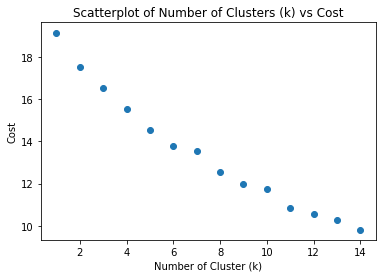

In [38]:
#plot cost values of k's as calculated above, 'elbow' as best k value
plt.scatter(best_k['Cost'],best_k['k'])
plt.title("Scatterplot of Number of Clusters (k) vs Cost")
plt.ylabel("Cost")
plt.xlabel("Number of Cluster (k)")
plt.show

As seen on the scatter plott, two k values present an 'elbow' point, k = 8 and k = 11. To keep the amount of clusters low, k = 8 is chosen.

In [39]:
#cluster neighborhoods by best k (lowest cost as calculated above, but at the same time fitting the data - see 'elbow' of line plot)
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 7, 0, 0, 0, 3, 3, 3, 3], dtype=int32)

### 4. Data aggregation and Visualization

Now, we aggregate all data processed in the steps before:
* Postal Code
* Borough
* Neighborhoods ...
* and their geographical data (lat, long)
* Cluster Label
* 10 most common venue types

Then, we visualize the cluster on a map of Toronto.

In [70]:
#new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = ca_post_code

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_clean = toronto_merged.dropna(subset=['Cluster Labels'], axis = 0, inplace = False)
toronto_merged_clean = toronto_merged_clean.astype({'Cluster Labels': int})

print(f'Shape: {toronto_merged_clean.shape}')
toronto_merged_clean.head()

Shape: (99, 16)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Print Shop,Event Space,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Department Store,Drugstore
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,3,History Museum,Bar,Women's Store,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Pizza Place,Electronics Store,Rental Car Location,Breakfast Spot,Intersection,Medical Center,Mexican Restaurant,Women's Store,Dog Run,Diner
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Coffee Shop,Korean Restaurant,Women's Store,Drugstore,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,Fried Chicken Joint,Hakka Restaurant,Athletics & Sports,Bakery,Bank,Thai Restaurant,Caribbean Restaurant,Doner Restaurant,Diner,Discount Store


In [46]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if folium is not installed
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if geopy is not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [44]:
#Use geopy library to get the latitude and longitude values of Toronto

address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of Toronto are {latitude}, {longitude}.')

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [45]:
#visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_clean['Latitude'], toronto_merged_clean['Longitude'], toronto_merged_clean['Neighborhood'], toronto_merged_clean['Cluster Labels']):
    label = folium.Popup(str(poi) + ' -- Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters